In [1]:
from torch import nn
import box_ops
import arrayfire as af
import numpy as np
import torch as torch
import skimage.io as io
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pycocotools.coco import COCO

In [2]:
dataDir='/datasets01/COCO/022719/'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [3]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, out_logits, out_bbox, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        # out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']
        print(len(out_logits))
        print(len(target_sizes))
        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results
    
class PostProcessLabel(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, labels, out_bbox, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """

        # convert to [x0, y0, x1, y1] format
        print(out_bbox.shape)
        print(out_bbox)
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        print(boxes)
        print(boxes.shape)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        print(scale_fct)
        print(scale_fct.shape)
        print(boxes)
        boxes = boxes * scale_fct[:, None, :]
        print(boxes)
        print(labels)
        print(labels.shape)
        labels = labels[:, :, 0]
        scores = np.ones(labels.shape) 
        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results
        
        """
        # out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        #assert len(out_logits) == len(target_sizes)
        #assert target_sizes.shape[1] == 2

        # convert to [x0, y0, x1, y1] format
        print(out_bbox.shape)
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        #img_h, img_w = target_sizes.unbind(1)
        img_h, img_w = imageSizes
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=0)
        print(scale_fct.shape)
        print(boxes.shape)
        boxes = boxes * scale_fct[None, :]
        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]
        return results
        """

In [4]:
def readOutput(f):
    imageSizes = af.read_array(f, key='imageSizes').to_ndarray()
    imageSizes = np.transpose(imageSizes, (1, 0))
    imageSizes = torch.from_numpy(imageSizes)

    imageIds = af.read_array(f, key='imageIds').to_ndarray()
    #print(imageIds.shape)
    #imageIds = np.transpose(imageIds, (1, 0))
    scores = af.read_array(f, key='scores').to_ndarray()
    scores = np.transpose(scores, (2, 1, 0))
    scores = torch.from_numpy(scores)
    bboxes = af.read_array(f, key='bboxes').to_ndarray()
    bboxes = np.transpose(bboxes, (2, 1, 0))
    bboxes = torch.from_numpy(bboxes)
    return (imageSizes, imageIds, scores, bboxes)

In [5]:
def readLabel(f):
    imageSizes = af.read_array(f, key='imageSizes').to_ndarray()
    imageSizes = np.expand_dims(imageSizes, 1)
    imageSizes = np.transpose(imageSizes, (1, 0))
    imageSizes = torch.from_numpy(imageSizes)
    imageIds = af.read_array(f, key='imageIds').to_ndarray()
    #imageIds = np.expand_dims(imageIds, 1)
    #imageIds = np.transpose(imageIds, (1, 0))
    scores = af.read_array(f, key='scores').to_ndarray()
    scores = np.expand_dims(scores, 2)
    #scores = np.transpose(scores, (1, 0))
    scores = np.transpose(scores, (2, 1, 0))
    scores = torch.from_numpy(scores)
    bboxes = af.read_array(f, key='bboxes').to_ndarray()
    print(bboxes.shape)
    bboxes = np.expand_dims(bboxes, 2)
    bboxes = np.transpose(bboxes, (2, 1, 0))
    bboxes = torch.from_numpy(bboxes)
    return (imageSizes, imageIds, scores, bboxes)

In [6]:
imageSizes, imageIds, scores, bboxes = readOutput('/private/home/padentomasello/scratch/detr_output/detection0.array')

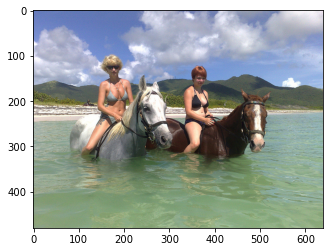

In [18]:
%matplotlib inline
import PIL
idx = 1 # Good 
idx = 3
#idx = 5
idx = 6
threshold = 0.5

imageId = imageIds[idx]
img_url = coco.loadImgs([imageId])[0]['coco_url']
I = io.imread(img_url)
plt.figure()
plt.imshow(I);

8
8
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'animal', 'id': 19, 'name': 'horse'}
{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'animal', 'id': 19, 'name': 'horse'}
{'supercategory': 'animal', 'id': 19, 'name': 'horse'}
{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'person', 'id': 1, 'name': 'person'}


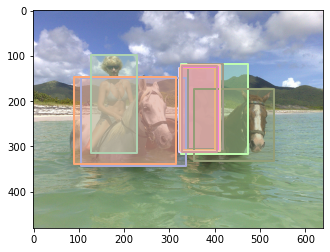

In [19]:
postprocess = PostProcess()
results = postprocess.forward(scores, bboxes, imageSizes)
imageIds = [ id for id in imageIds ];
res = { id : output for id, output in zip(imageIds, results) };
results = prepare_for_coco_detection(res)


results = [ result for result in results if result['score'] >= threshold]
cocoDt = coco.loadRes(results)
plt.figure()
plt.imshow(I);

annIds = cocoDt.getAnnIds([imageId])
anns = cocoDt.loadAnns(annIds)
cocoDt.showAnns(anns)

categories = [res['category_id'] for res in anns]
cats = coco.loadCats(categories)
#print(list(cats))
for cat in cats:
    print(cat)

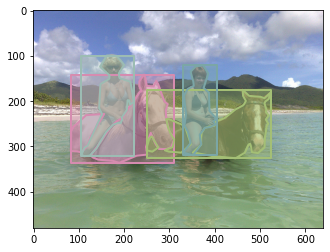

In [20]:
plt.imshow(I);
annIds = coco.getAnnIds([imageId])
anns = coco.loadAnns(annIds)
coco.showAnns(anns, True)
categories = [res['category_id'] for res in anns]
#coco.loadCats(categories)

In [43]:
from pycocotools.cocoeval import COCOeval
cocoEval = COCOeval(coco, cocoDt, 'bbox')
cocoEval.params.imgIds  = [imageId]
                           
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.883
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.675
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1

In [260]:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.033

SyntaxError: invalid syntax (<ipython-input-260-a30ca7548773>, line 1)

In [511]:
len(coco.getImgIds())

5000

In [474]:
cocoGt2 = coco.loadRes(coco.loadAnns(coco.getAnnIds([imageId])))
#cocoGt2.showAnns(anns, True)

results2 = [ res for res in results if res['image_id'] == imageId ]
cocoDt2 = coco.loadRes(results2)

cocoEval2 = COCOeval(cocoGt2, cocoDt2, 'bbox')
#cocoEval.params.imgIds  = [imageId]
cocoEval2.evaluate()
cocoEval2.accumulate()
cocoEval2.summarize()

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.14s).
Accumulating evaluation results...
DONE (t=0.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets